In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Getting started: Ensembling Multiple Models with NVIDIA Triton Inference Server with a custom container

<table align="left">
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/vertex_endpoints/nvidia-triton/get_started_with_triton_ensemble.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/vertex_endpoints/nvidia-triton/get_started_with_triton_ensemble.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>  
</table>


## Overview

This tutorial shows how to use a custom container running [NVIDIA Triton Inference Server (Triton)](https://developer.nvidia.com/nvidia-triton-inference-server) to deploy multiple models including an ensembled model on [Vertex AI Prediction](https://cloud.google.com/vertex-ai/docs/predictions/getting-predictions) that serves online predictions.

Learn more about [Vertex AI Prediction](https://cloud.google.com/vertex-ai/docs/predictions/get-predictions).


### Objective

In this tutorial, you deploy a custom container running Nvidia Triton Server to serve predictions from an ensembled model 
REDO
and then use the Vertex AI Endpoints to detect objects in an image.

The steps performed in this tutorial include:

- Create Triton configuration files for multiple pre-built models
- Pull a custom serving container running Triton
- Upload the Triton multiple model package as a Vertex `Model` resource
- Deploy the `Model` resource to a serving `Endpoint` resource.
- Make a prediction request as individual models.
- Make a prediction request as a model ensemble.
- Undeploy the `Model` resource and delete the `Endpoint`

### Dataset

The notebook uses random data generator to train and serve the models.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## NVIDIA Triton Inference Server (Triton) Overview

[NVIDIA Triton Inference Server (Triton)](https://github.com/triton-inference-server/server) provides an inference solution optimized for both CPUs and GPUs. Triton can run multiple models from the same or different frameworks concurrently on a single GPU or CPU. In a multi-GPU server, it automatically creates an instance of each model on each GPU to increase utilization without extra coding. It supports real-time inferencing, batch inferencing to maximize GPU/CPU utilization, and streaming inference with built-in support for audio streaming input. It also supports model ensembles for use cases that require multiple models to perform end-to-end inference.

The following figure shows the Triton's high-level architecture.

![Triton high level architecture](https://raw.githubusercontent.com/triton-inference-server/server/main/docs/user_guide/images/arch.jpg)

- The model repository is a file-system based repository of the models that Triton will make available for inference.
- Inference requests arrive at the server via either HTTP/REST or gRPC and are then routed to the appropriate per-model scheduler.
- Triton implements multiple scheduling and batching algorithms that can be configured on a model-by-model basis.
- The backend performs inference using the inputs provided in the batched requests to produce the requested outputs.

Triton provides readiness and liveness health endpoints, as well as utilization, throughput, and latency metrics, which enable the integration of Triton into deployment environments, such as Vertex AI Prediction.

Refer to [Triton architecture](https://github.com/triton-inference-server/server/blob/main/docs/architecture.md) for more detailed information.

## Triton on Vertex AI Prediction

Triton inference server runs inside a container published by NVIDIA GPU Cloud (NGC) - [NVIDIA Triton Inference Server Image](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver). NVIDIA and GCP Vertex AI team collaborated and added packages and configurations to align Triton with Vertex AI [requirements for custom serving container images](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements).

The model to be served by Triton should be registered with Vertex AI as a `Model` resource. The `Model`'s metadata refer to a location of the ensemble artifacts in Cloud Storage and the custom serving container including configuration.

Triton loads the models and exposes inference, health, and model management REST endpoints using [standard inference protocols](https://github.com/kserve/kserve/tree/master/docs/predict-api/v2). While deploying to Vertex AI, Triton recognizes Vertex AI environment and adopts Vertex AI Prediction protocol for [health checks](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements#health) and predictions.

To invoke the model through the Vertex AI Endpoint, format prediction request using a [standard Inference Request JSON Object](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference) or a [Inference Request JSON Object with a binary extension](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md) and submit a request to Vertex AI Prediction [REST rawPredict endpoint](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/projects.locations.endpoints/rawPredict). You need to use the `rawPredict` rather than `predict` method because inference request formats used by Triton are not compatible with the Vertex AI Prediction [standard input format](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#formatting-prediction-input).

![triton-on-vertex-ai-predictions](https://cloud.google.com/vertex-ai/docs/predictions/images/using-triton-on-vertex-ai-predictions-architecture.png)

## Set up your local development environment

This notebook is only supported on [Vertex AI Workbench](https://cloud.google.com/vertex-ai/docs/workbench/introduction), and the Vertex AI Workbench environment already meets all the requirements to run this notebook. Please make sure you are running the notebook in TensorFlow kernel in the Vertex AI Workbench notebook environment.

**NOTE:** This notebook uses `docker` commands to build and test the containers in the local development environment before deploying a custom container to Vertex AI Predictions. [Google Colab currently does not natively support running docker](https://github.com/googlecolab/colabtools/issues/299#issuecomment-615308778) and hence the notebook is supported only on Vertex AI Workbench.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
# Install the packages
! pip3 install --user --upgrade google-cloud-aiplatform

! pip3 install tritonclient geventhttpclient transformers

## Before you begin

### GPU runtime

This tutorial does not require a GPU runtime.

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the following APIs: Vertex AI APIs, Compute Engine APIs, and Cloud Storage.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component,storage-component.googleapis.com)

4. [The Google Cloud SDK](https://cloud.google.com/sdk) is already installed in Google Cloud Notebook.

5. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$`.

In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations)

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

#### Authenticate your Google Cloud account

**If you are running Notebook from Vertex AI Workbench, your environment is already authenticated.**

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you initialize the Vertex SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [ ]:
BUCKET_URI = "gs://your-bucket-name-unique"  # @param {type:"string"}

---

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

---

In [ ]:
! gsutil mb -l $REGION $BUCKET_URI

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_URI

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries

In [ ]:
import json
import os

import numpy as np
import tritonclient.http as triton_http
from google.api import httpbody_pb2
from google.cloud import aiplatform as aip
from google.cloud import aiplatform_v1 as gapic

### Define constants

`MODEL_ARTIFACTS_REPOSITORY` - the Cloud Storage location where the Triton model artifacts are stored.

In [ ]:
MODEL_ARTIFACTS_REPOSITORY = (
    "gs://cloud-samples-data/vertex-ai/model-deployment/models/triton_models"
)

The following set of constants will be used to create names and display names of Vertex AI Prediction resources like models, endpoints, and model deployments.

In [ ]:
# set model names and version
MODEL_NAME = "ensemble"
MODEL_VERSION = "v01"
MODEL_DISPLAY_NAME = f"triton-{MODEL_NAME}-{MODEL_VERSION}"
ENDPOINT_DISPLAY_NAME = f"endpoint-{MODEL_NAME}-{MODEL_VERSION}"

# You can get the latest Triton image uri from
# https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
NGC_TRITON_IMAGE_URI = "nvcr.io/nvidia/tritonserver:22.05-py3"

# prediction container image name
IMAGE_NAME = "vertex-triton-inference:22.05"

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

## Prepare model artifacts

The `config.pbtxt` file describes the [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) for the ensemble model. For example:

> ```
> └── model-repository-path
>        └── model_name
>               ├── config.pbtxt
>               └── 1
>                   └── model.savedmodel
>                         └── <saved-model-files>
> ```

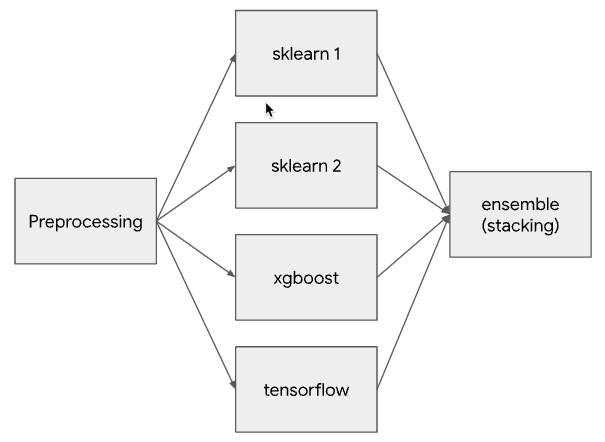

### Prebuilt models for the ensemble

Next, view the prebuild models you use in this model ensemble.

In [ ]:
! gsutil ls -R {MODEL_ARTIFACTS_REPOSITORY}

### Create model configuration file

The [model configuration](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md) file `config.pbtxt` provides information about the model such as inputs and outputs. Refer to the [Triton docs](https://github.com/triton-inference-server/common/blob/main/protobuf/model_config.proto) for the configuration format. For TensorFlow models, you could use the [`saved_model_cli` command](https://www.tensorflow.org/guide/saved_model#details_of_the_savedmodel_command_line_interface) and map to the Triton's configuration format. Note that Triton datatypes are different from the frameworks and should be mapped accordingly based on the table [here](https://github.com/triton-inference-server/server/blob/main/docs/model_configuration.md#datatypes).

In [ ]:
! gsutil cat {MODEL_ARTIFACTS_REPOSITORY}/ensemble/config.pbtxt

## Building and pushing the container image

To use a custom container for serving predictions, you specify a Docker container image that meets the [custom container requirements](https://cloud.google.com/vertex-ai/docs/predictions/custom-container-requirements). This section describes how to create the container image running Triton and push it to the Artifact Registry.

### Setting up Artifact Registry

- **Enable the Artifact Registry API service for your project.**

In [ ]:
! gcloud services enable artifactregistry.googleapis.com

- **Create a private Docker repository to push the container images**

In [ ]:
DOCKER_ARTIFACT_REPO = "triton-prediction-container"

In [ ]:
# create a new Docker repository with your region with the description
! gcloud artifacts repositories create {DOCKER_ARTIFACT_REPO} \
    --repository-format=docker \
    --location={REGION} \
    --description="Triton Docker repository"

# verify that your repository was created.
! gcloud artifacts repositories list \
    --location={REGION} \
    --filter="name~"{DOCKER_ARTIFACT_REPO}

- **Configure authentication to the private repo**

Before you push or pull container images, configure Docker to use the `gcloud` command-line tool to authenticate requests to Artifact Registry for your region.

In [ ]:
! gcloud auth configure-docker {REGION}-docker.pkg.dev --quiet

- **Build the image and tag the Artifact Registry path that the image will be pushed to**

In [ ]:
IMAGE_URI = f"{REGION}-docker.pkg.dev/{PROJECT_ID}/{DOCKER_ARTIFACT_REPO}/{IMAGE_NAME}"

In [ ]:
%%bash -s $NGC_TRITON_IMAGE_URI

export NGC_TRITON_IMAGE_URI=$1

cat <<EOF > Dockerfile

FROM $NGC_TRITON_IMAGE_URI AS triton

RUN pip3 install transformers

EOF

In [ ]:
! docker build -t $IMAGE_URI .

### Run the container locally *[optional]*

Before pushing the custom container image to Artifact Registry to use it with Vertex AI Predictions, run the container in local environment to verify that the server responds to prediction instances.


#### Start running the container image

To run the container image as a container locally, run the following command:

In [ ]:
! docker stop ensemble 2>/dev/stderr
! docker run -t -d -p 8000:8000 --rm \
    --name=ensemble \
    -e AIP_MODE=True \
    --shm-size=256m \
    --gpus all \
    $IMAGE_URI \
    --model-repository $MODEL_ARTIFACTS_REPOSITORY
! sleep 20

In [ ]:
# check if the triton container is running locally
!docker container ls -f"name=ensemble" --no-trunc

#### Perform health check

To send the container's server a health check, run the following command. It should return the status code as `200`

In [ ]:
! curl -s -o /dev/null -w "%{http_code}" http://localhost:8000/v2/health/ready

#### Send a prediction request

To send the container's server a prediction request, run the following script with the sample payload based on the model type (scikit-learn, xgboost, tensorflow, ensemble) and get prediction responses

In [ ]:
def get_triton_prediction_local(model_name, url="localhost:8000", headers=None):
    # set up both HTTP and GRPC clients. Note that the GRPC client is generally
    # somewhat faster.
    http_client = triton_http.InferenceServerClient(
        url=url, verbose=False, concurrency=5
    )

    # generate example data to classify
    features = 4
    samples = 1
    data = np.random.rand(samples, features).astype("float32")

    # payload configuration defining input and output names
    payload_config = {
        "sci_1": {"input": "input__0", "output": "output__0"},
        "sci_2": {"input": "input__0", "output": "output__0"},
        "xgb": {"input": "input__0", "output": "output__0"},
        "tf": {"input": "dense_input", "output": "round"},
        "ensemble": {"input": "INPUT0", "output": "OUTPUT0"},
    }

    # get input and output names based on model name
    input_name = payload_config[model_name]["input"]
    output_name = payload_config[model_name]["output"]

    # set up Triton input and output objects for HTTP
    triton_input_http = triton_http.InferInput(input_name, (samples, features), "FP32")
    triton_input_http.set_data_from_numpy(data, binary_data=False)
    triton_output_http = triton_http.InferRequestedOutput(
        output_name, binary_data=False
    )

    # submit inference request
    request_http = http_client.infer(
        model_name,
        model_version="1",
        inputs=[triton_input_http],
        outputs=[triton_output_http],
        headers=headers,
    )

    # get results as numpy arrays
    result_http = request_http.as_numpy(output_name)
    print(f"request: {data}")
    print(f"response: {result_http}")

In [ ]:
# model names: sci_1, sci_2, xgb, tf, ensemble
TRITON_URL = "localhost:8000"

for model_name in ["sci_1", "sci_2", "xgb", "tf", "ensemble"]:
    print(f"Predictions from model: {model_name}")
    get_triton_prediction_local(model_name, TRITON_URL)
    print("-" * 16)

#### Stop running the container

To stop the container, run the following command:

In [ ]:
! docker stop ensemble

### Push the container image to Artifact Registry

After testing the container image locally, push the image to Artifact Registry. The Artifact Registry image URI will be used when creating the Vertex AI model resource.

In [ ]:
! docker push $IMAGE_URI

## Create Vertex AI Model resource

A  Vertex AI Model resource must be created to deploy the model to a Vertex AI Prediction Endpoint. Create a Vertex AI Model resource with the deployment image pointing to the model artifacts. Refer to [Vertex AI Prediction guide](https://cloud.google.com/vertex-ai/docs/predictions/use-custom-container) for creating Vertex AI Model resource with custom container.

In [ ]:
print(f"MODEL_ARTIFACTS_REPOSITORY = {MODEL_ARTIFACTS_REPOSITORY}")
print(f"MODEL_DISPLAY_NAME = {MODEL_DISPLAY_NAME}")
print(f"IMAGE_URI = {IMAGE_URI}")

In [ ]:
model = aip.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    serving_container_image_uri=IMAGE_URI,
    artifact_uri=MODEL_ARTIFACTS_REPOSITORY,
    sync=True,
    serving_container_args=[
        "--backend-config=tensorflow,version=2",
        "--backend-config=tensorflow,transfer_threshold=0",
        "--backend-config=python,shm-default-byte-size=33554432,shm-growth-byte-size=8388608",
        "--backend-config=fil,transfer_threshold=0",
        "--vertex-ai-default-model=ensemble",
        "--strict-model-config=true",
        "--log-verbose=99",
        "--log-error=1",
    ],
)

print(model.resource_name)

## Deploy the model to Vertex AI Predictions

Deploying a Vertex AI Model is a two step process.

1. Create an `Endpoint` exposing an external interface to users consuming the model. 
2. After the `Endpoint` is ready, deploy multiple versions of a model to the `Endpoint`. The deployed model runs the custom container image running Triton to serve predictions.

### Create an endpoint

Before deploying the `Model` you created a `Vertex AI Endpoint`.

In [ ]:
endpoint = aip.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)

### Deploy model to an endpoint

After the `Endpoint` is ready, deploy the `Model` to the `Endpoint`.The deployed model runs the Triton Server on a GPU node equipped with the NVIDIA Tesla T4 GPUs. 

Learn more about[Deploy a model using the Vertex AI API](https://cloud.google.com/vertex-ai/docs/predictions/deploy-model-api) guide for more information.

**NOTE:** This step can take up to 20 min.

In [ ]:
traffic_percentage = 100
machine_type = "n1-standard-4"
accelerator_type = "NVIDIA_TESLA_T4"
accelerator_count = 1
min_replica_count = 1
max_replica_count = 2

model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=MODEL_DISPLAY_NAME,
    machine_type=machine_type,
    min_replica_count=min_replica_count,
    max_replica_count=max_replica_count,
    traffic_percentage=traffic_percentage,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    sync=True,
)

print(endpoint.name)

## Invoking the model and getting predictions

To invoke the model through Vertex AI Prediction endpoint, format prediction request using a [standard Inference Request JSON Object](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference) or a [Inference Request JSON Object with a binary extension](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md) and submit the request to Vertex AI Prediction [REST rawPredict endpoint](https://cloud.google.com/vertex-ai/docs/reference/rest/v1beta1/projects.locations.endpoints/rawPredict). 

---

Instead of `predict` API, you must use the `rawPredict` API  because prediction request formats used by Triton are not compatible with the Vertex AI Prediction [standard input format](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models#formatting-prediction-input).

---

In the [previous section](#Download-test-image-file-and-generate-payload-to-make-prediction-requests) the request body was formatted as a [standard Inference Request JSON Object](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/required_api.md#inference).

**You can invoke the Vertex AI Prediction `rawPredict` endpoint using [Vertex AI SDK](https://googleapis.dev/python/aiplatform/latest/aiplatform_v1/prediction_service.html#:~:text=async-,raw_predict,-(request%3A%20Optional%5BUnion), any HTTP tool or library, including `curl`.**

To use `Endpoint` in another session: set endpoint as following

```
endpoint = aip.Endpoint('projects/<project-number>/locations/<region>/endpoints/<endpoint-id>')
```

### Calling `rawPredict` using Vertex AI SDK to get prediction response

The function below calls the Triton inference server deployed on Vertex AI Endpoint with the Endpoint resource name, model name to call when multiple models are deployed on Triton inference server on the same Endpoint and additional headers to pass to the Triton inference server.

In [ ]:
def get_triton_prediction_vertex(
    model_name,
    endpoint_name,
    api_endpoint=f"{REGION}-aiplatform.googleapis.com",
    headers=None,
):
    # set up vertex ai prediction client
    client_options = {"api_endpoint": api_endpoint}
    gapic_client = gapic.PredictionServiceClient(client_options=client_options)

    # generate example data to classify
    features = 4
    samples = 1
    data = np.random.rand(samples, features).astype("float32")

    # payload configuration defining input and output names
    payload_config = {
        "sci_1": {"input": "input__0", "output": "output__0"},
        "sci_2": {"input": "input__0", "output": "output__0"},
        "xgb": {"input": "input__0", "output": "output__0"},
        "tf": {"input": "dense_input", "output": "round"},
        "ensemble": {"input": "INPUT0", "output": "OUTPUT0"},
        "mux": {
            "input": "mux_in",
            "output": ["mux_xgb_out", "mux_tf_out", "mux_sci_1_out", "mux_sci_2_out"],
        },
    }

    # get input and output names based on model name
    input_name = payload_config[model_name]["input"]
    output_name = payload_config[model_name]["output"]

    # set up Triton input and output objects for HTTP
    triton_input_http = triton_http.InferInput(input_name, (samples, features), "FP32")
    triton_input_http.set_data_from_numpy(data, binary_data=False)

    if isinstance(output_name, list):
        triton_output_http = [
            triton_http.InferRequestedOutput(output, binary_data=False)
            for output in output_name
        ]

    else:
        triton_output_http = [
            triton_http.InferRequestedOutput(output_name, binary_data=False)
        ]

    # create inference request
    _data, _ = triton_http._get_inference_request(
        inputs=[triton_input_http],
        outputs=triton_output_http,
        request_id="",
        sequence_id=0,
        sequence_start=False,
        sequence_end=False,
        priority=0,
        timeout=None,
    )
    http_body = httpbody_pb2.HttpBody(
        data=_data.encode("utf-8"), content_type="application/json"
    )
    print(f"request: {data}")
    # submit inference request
    request = gapic.RawPredictRequest(endpoint=endpoint_name, http_body=http_body)
    response = gapic_client.raw_predict(request=request, metadata=headers)
    # get result as json
    result_http = json.loads(response.data.decode("utf-8"))
    print(f"response: {result_http['outputs'][0]['data']}")

#### Make model ensemble prediction request

Call the Vertex AI Endpoint to get prediction responses from Triton server from the multiple of models deployed including an ensembled model.

In [ ]:
endpoint_name = endpoint.resource_name

# model names: sci_1, sci_2, xgb, tf, ensemble
for model_name in ["sci_1", "sci_2", "xgb", "tf", "ensemble"]:
    print(f"Predictions from model: {model_name}")
    headers = {"x-vertex-ai-triton-redirect": f"v2/models/{model_name}/infer"}
    get_triton_prediction_vertex(
        model_name, endpoint_name, headers=tuple(headers.items())
    )
    print("-" * 16)

#### Example sample to call Vertex AI Endpoint with a payload file instead of generating payload inline

In [ ]:
# initialize service client
client_options = {"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
prediction_client = gapic.PredictionServiceClient(client_options=client_options)

payload_file = "payload_ensemble.json"

In [ ]:
%%bash -s $payload_file

payload_file=$1
echo "Writing $payload_file"

cat <<EOF > $payload_file
{"id": "0", "inputs": [{"name": "INPUT0", "shape": [1, 4], "datatype": "FP32", "parameters": {}, "data": [0.6060078144073486, 0.2473181188106537, 0.5559595227241516, 0.8552274703979492]}]}
EOF

#### Format the http request

In [ ]:
# format payload
http_body = httpbody_pb2.HttpBody(
    data=open(payload_file).read().encode("utf-8"),
    content_type="application/json",
)

print(http_body)

# Initialize request argument(s)
request = gapic.RawPredictRequest(endpoint=endpoint_name, http_body=http_body)

**Make the prediction request**

In [ ]:
# Make the prediction request
response = prediction_client.raw_predict(request=request)
result = json.loads(response.data)

print(result)

### Making `curl` request to get prediction response

Notice the use of `rawPredict` API endpoint in the URI below

In [ ]:
endpoint_uri = f"https://{REGION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint.name}:rawPredict"

Create payload specific for TensorFlow model instead of default ensemble model

In [ ]:
%%bash

echo "Writing payload for TensorFlow model"

cat <<EOF > payload_tf.json
{"id": "0", "inputs": [{"name": "dense_input", "shape": [1, 4], "datatype": "FP32", "parameters": {}, "data": [0.3097294569015503, 0.5998961329460144, 0.09703510254621506, 0.11341036856174469], "raw_data": null}]}
EOF

Add additional header to infer from TensorFlow model instead of default model (multiple models were deployed on the endpoint)

In [ ]:
! curl -X POST \
   -H "Authorization: Bearer $(gcloud auth print-access-token)" \
   -H "Content-Type: application/json"  \
   -H "Accept: */*" \
   -H "X-Vertex-Ai-Triton-Redirect: v2/models/tf/infer" \
   $endpoint_uri \
   -d @payload_tf.json

## Cleaning up 

### Cleaning up training and deployment resources

To clean up all Google Cloud resources used in this notebook, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Model
- Endpoint
- Cloud Storage Bucket
- Container Images

In [ ]:
delete_endpoint = True
delete_model = True
delete_bucket = False
delete_image = True

# Delete the endpoint using the Vertex AI fully qualified identifier for the endpoint
try:
    if delete_endpoint or os.getenv("IS_TESTING"):
        # get endpoint resource
        endpoints = aip.Endpoint.list(
            filter=f"display_name={ENDPOINT_DISPLAY_NAME}", order_by="create_time"
        )
        endpoint = endpoints[0]
        # undeploy models from the endpoint
        print(
            f"Undeploying all deployed models from the endpoint {endpoint.display_name} [{endpoint._gca_resource.name}]"
        )
        endpoint.undeploy_all(sync=True)
        # deleting endpoint
        print(
            f"Deleting endpoint {endpoint.display_name} [{endpoint._gca_resource.name}]"
        )
        aip.Endpoint.delete(endpoint)
        print(f"Deleted endpoint {endpoint.display_name}")
except Exception as e:
    print(e)

#### **Deleting models**

In [ ]:
# Delete the model using the Vertex AI fully qualified identifier for the model
try:
    if delete_model or os.getenv("IS_TESTING"):
        # get model resource
        models = aip.Model.list(
            filter=f"display_name={MODEL_DISPLAY_NAME}", order_by="create_time"
        )
        for model in models:
            # deleting model
            print(f"Deleting model {model.display_name} [{model._gca_resource.name}]")
            aip.Model.delete(model)
            print(f"Deleted model {model.display_name}")
except Exception as e:
    print(e)

#### **Delete contents from the staging bucket**

---

***NOTE: Everything in this Cloud Storage bucket will be DELETED. Please run it with caution.***

---

In [ ]:
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -r $BUCKET_NAME
    
rm -f Dockerfile payload_*.json

#### **Delete images from Artifact Registry**

Deletes all the container images created in this tutorial with name defined by variable `IMAGE_NAME` from the registry. All associated tags are also deleted.

In [ ]:
gar_images = ! gcloud artifacts docker images list $REGION-docker.pkg.dev/$PROJECT_ID/$DOCKER_ARTIFACT_REPO \
      --filter="package~"$(echo $IMAGE_NAME | sed 's/:.*//') \
      --format="get(package)"

try:
    if delete_image or os.getenv("IS_TESTING"):
        for image in gar_images:
            # delete only if image name starts with valid region
            if image.startswith(f'{REGION}-docker.pkg.dev'):
                print(f"Deleting image {image} including all tags")
                ! gcloud artifacts docker images delete $image --delete-tags --quiet
except Exception as e:
    print(e)

### Cleaning up Notebook Environment

After you are done experimenting, you can either [STOP](https://cloud.google.com/ai-platform/notebooks/docs/shut-down) or DELETE the AI Notebook instance to prevent any  charges. If you want to save your work, you can choose to stop the instance instead.

```
# Stopping Notebook instance
gcloud notebooks instances stop example-instance --location=us-central1-a


# Deleting Notebook instance
gcloud notebooks instances delete example-instance --location=us-central1-a
```